In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# iPLS

This notebook will implement interval partial least squares.

In [2]:
import logging

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from smelly_rats.loader import load_smelly_rats
from smelly_rats import modeling


logging.basicConfig(
    format='%(message)s',
    level=logging.INFO
)

In [3]:
hnmr_spectra, target = load_smelly_rats('../data/rats-and-onions.xls')

# Interval partial least squares

In [4]:
num_intervals = 20      # number of spectral intervals

mod = Pipeline([
    ('scaling', modeling.ParetoScaler(with_mean=True)),
    ('spectral_band', modeling.BandSelector(9, 7)),
    ('regressor', PLSRegression(n_components=7, scale=False))
])

intervals = np.linspace(
    hnmr_spectra.index.max(), 
    hnmr_spectra.index.min(), 
    num_intervals + 1
)

param_grid = {
    'spectral_band': (
        [modeling.BandSelector(start, stop) for start, stop in zip(intervals[:-1], intervals[1:])] 
        + [modeling.BandSelector(intervals.max(), intervals.min())]
    ),
}

grid = GridSearchCV(
    mod,
    param_grid,
    cv=5,
    iid=False,
    scoring=modeling.rmse,
    return_train_score=True
)

grid.fit(hnmr_spectra.T, target['y'])
grid.best_estimator_

/Users/cor/github/rats-and-onions/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Pipeline(memory=None,
         steps=[('scaling', ParetoScaler(with_mean=True)),
                ('spectral_band',
                 BandSelector(start=3.5721066992221653, stop=3.1076269006446857)),
                ('regressor',
                 PLSRegression(copy=True, max_iter=500, n_components=7,
                               scale=False, tol=1e-06))],
         verbose=False)

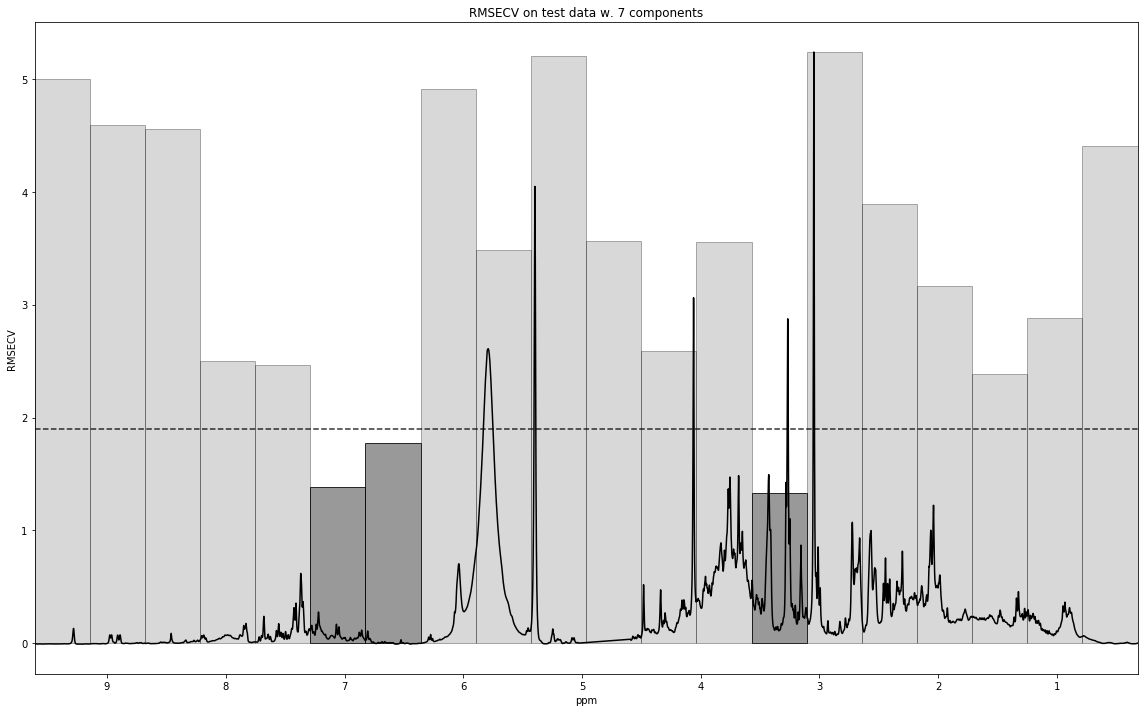

In [5]:
def plot_cv_ipls(cv_results, ax, *, train_test='test', show_yerr=True):
    global_score = (
        cv_results
        .loc[lambda df: df['start'] == df['start'].max()]
        .loc[lambda df: df['stop'] == df['stop'].min()]
        [f'mean_{train_test}_score']
        .values[0]
    )
    
    capsize = 7 if show_yerr else 0
    for _, row in cv_results.iterrows():
        start = row['start']
        stop = row['stop']
        height = row[f'mean_{train_test}_score']
        yerr = row[f'std_{train_test}_score'] if show_yerr else 0

        if start == intervals.max() and stop == intervals.min():        # global
            ax.axhline(height, linestyle='--', color='black', alpha=0.8)
            if show_yerr:
                ax.axhline(height - yerr, linestyle='-.', color='black', alpha=0.8)
                ax.axhline(height + yerr, linestyle='-.', color='black', alpha=0.8)
        else:                                                          # interval
            alpha = 0.3 if height > global_score else 0.8
            ax.bar(
                stop, 
                height=height, 
                width=(start - stop), 
                align='edge', 
                color='grey',
                alpha=alpha,
                edgecolor='black',
                yerr=yerr,
                capsize=capsize,
            )
            
    ax.set_xlim([cv_results['start'].max(), cv_results['stop'].min()])
    ax.set_xlabel('ppm')
    ax.set_ylabel('RMSECV')
    ax.set_xticks(np.arange(
        np.floor(cv_results['start'].max()), 
        np.floor(cv_results['stop'].min()),
        -1,
    ))
    return ax


def plot_hnmr_spectra(df, ax, train_test='test'):
    plotr = (
        df
        .mean(axis=1)
        .transform(lambda series: series / series.max())
        .transform(lambda series: series * cv_results[f'mean_{train_test}_score'].max())
    )
    return plotr.plot(ax=ax, color='black')


cv_results = (
    pd.DataFrame(grid.cv_results_)
    .assign(start=lambda df: [row['spectral_band'].start for row in df['params']],
            stop=lambda df: [row['spectral_band'].stop for row in df['params']],
            mean_test_score=lambda df: -df['mean_test_score'],
            mean_train_score=lambda df: -df['mean_train_score'])
)

fig, ax = plt.subplots(1, figsize=(16, 10))
plot_hnmr_spectra(hnmr_spectra, ax)
plot_cv_ipls(cv_results, ax, train_test='test', show_yerr=False)
ax.set_title(f'RMSECV on test data w. 7 components')
fig.tight_layout();